In [1]:
import os

# for handling datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to handle images
from PIL import Image

# for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [ ]:
train_data_dir = rf'./2750'

In [ ]:
data = {}
img_height, img_width = 0, 0
for path, dirs, files in os.walk(train_data_dir):
    dir_name = path.split('/')[-1]
    first_file = files[0]
    file_name, file_ext = first_file.split('.')
    if file_ext == 'jpg':
        image = Image.open(f'{path}/{first_file}')
        img_width, img_height = image.size
        data[dir_name] = {'count': len(files), 'height': img_height, 'width': img_width}

df = pd.DataFrame.from_dict(data, orient='index')
print(df.head(10))

NameError: name 'os' is not defined

In [ ]:
img_height, img_width = 224, 224

In [ ]:
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [ ]:
# get class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'number of classes: {num_classes}', class_names)

number of classes: 10 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
class2idx = {name : i for i, name in enumerate(class_names)}
idx2class = {i : name for name, i in class2idx.items()}

In [ ]:
print(class2idx)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
print(idx2class)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
# retrieve a single batch of 32 images.
image_batch, label_batch = next(iter(train_dataset))

In [ ]:
print(image_batch.shape)
print(label_batch.shape)

(32, 224, 224, 3)
(32,)


In [ ]:
# check image value range
first_image = image_batch[0].numpy().astype("uint8")
print(np.min(first_image), np.max(first_image))

32 117


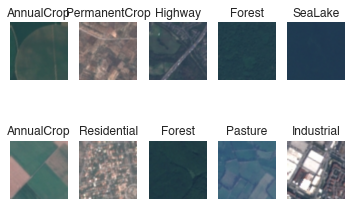

In [ ]:
plt.figure()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [ ]:
# cache and prefetch for computational efficiency

# buffered prefetching yields data from disk without incurring I/O blocking
# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch
# Dataset.prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
rescaling_layer = tf.keras.layers.Rescaling(
    scale=1. / 255,
    input_shape=(img_height, img_width, 3)
)

In [ ]:
# rescale data outside of model
rescaled_ds = train_dataset.map(lambda x, y: (rescaling_layer(x), y))
image_batch, labels_batch = next(iter(rescaled_ds))
first_image = image_batch[0].numpy().astype("float32")
print(np.min(first_image), np.max(first_image))

0.1817727 0.5683474


In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [ ]:
model = Sequential([

    # layer 1 - preprocessing layer with convolution and max pooling
    rescaling_layer,
    layers.Conv2D(filters=8, kernel_size=3, padding='same',
                  activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 4 - convolutional layer and max pooling
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.1),
    layers.Flatten(),

    # layer 5 - dense fully connected layer
    layers.Dense(units=128, activation='relu'),

    # layer 6 - output dense layer
    layers.Dense(num_classes)
])

In [ ]:
# compile tensorflow sequential CNN model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
model.save(f'{os.getcwd()}/land_cover_model')

Epoch 1/10


2022-07-27 17:06:56.360562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - ETA: 0s - loss: 1.1646 - accuracy: 0.5643

2022-07-27 17:07:57.332259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - 66s 95ms/step - loss: 1.1646 - accuracy: 0.5643 - val_loss: 0.8990 - val_accuracy: 0.6669
Epoch 2/10
675/675 [==============================] - 77s 114ms/step - loss: 0.6933 - accuracy: 0.7515 - val_loss: 0.5915 - val_accuracy: 0.7874
Epoch 3/10
675/675 [==============================] - 71s 106ms/step - loss: 0.5219 - accuracy: 0.8165 - val_loss: 0.6938 - val_accuracy: 0.7613
Epoch 4/10
675/675 [==============================] - 74s 110ms/step - loss: 0.4152 - accuracy: 0.8549 - val_loss: 0.5359 - val_accuracy: 0.8200
Epoch 5/10
675/675 [==============================] - 82s 121ms/step - loss: 0.3229 - accuracy: 0.8881 - val_loss: 0.5560 - val_accuracy: 0.8035
Epoch 6/10
675/675 [==============================] - 74s 110ms/step - loss: 0.2323 - accuracy: 0.9191 - val_loss: 0.5015 - val_accuracy: 0.8419
Epoch 7/10
675/675 [==============================] - 71s 106ms/step - loss: 0.1796 - accuracy: 0.9379 - val_loss: 0.5734 - val_accuracy: 0.83

INFO:tensorflow:Assets written to: /Users/shrut/Projects/LandCover/land_cover_model/assets


INFO:tensorflow:Assets written to: /Users/shrut/Projects/LandCover/land_cover_model/assets


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

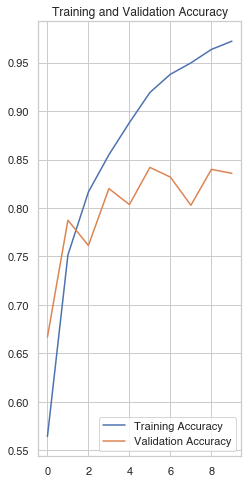

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

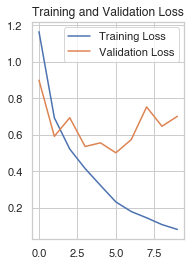

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet

In [ ]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width, 3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)


In [ ]:
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(0.5))
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

resnet_history = resnet_model.fit(train_dataset, validation_data=validation_dataset, epochs=5)

Epoch 1/5


2022-07-27 19:24:09.397371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9110

2022-07-27 19:28:15.052438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - 308s 453ms/step - loss: 0.2806 - accuracy: 0.9110 - val_loss: 0.1691 - val_accuracy: 0.9452
Epoch 2/5
675/675 [==============================] - 414s 613ms/step - loss: 0.1207 - accuracy: 0.9577 - val_loss: 0.1774 - val_accuracy: 0.9443
Epoch 3/5
675/675 [==============================] - 301s 446ms/step - loss: 0.0866 - accuracy: 0.9703 - val_loss: 0.1665 - val_accuracy: 0.9535
Epoch 4/5
675/675 [==============================] - 304s 450ms/step - loss: 0.0658 - accuracy: 0.9772 - val_loss: 0.2126 - val_accuracy: 0.9450
Epoch 5/5
675/675 [==============================] - 314s 466ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 0.2143 - val_accuracy: 0.9465


In [ ]:
resnet_model.save(f'{os.getcwd()}/resnet_land_cover_model')

INFO:tensorflow:Assets written to: /Users/shrut/Projects/LandCover/resnet_land_cover_model/assets


INFO:tensorflow:Assets written to: /Users/shrut/Projects/LandCover/resnet_land_cover_model/assets


In [ ]:
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

In [ ]:
epochs_range = range(5)

Text(0.5, 1.0, 'Training and Validation Accuracy')

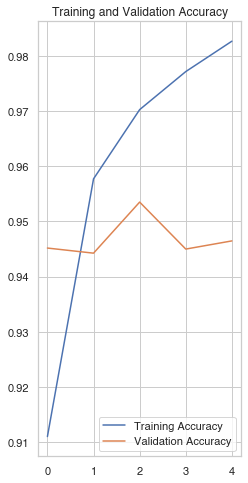

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

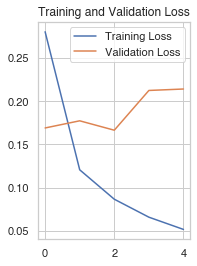

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_json = resnet_model.to_json()

In [ ]:
with open("model.json", "w") as json_file:
    json_file.write(resnet_json)
resnet_model.save_weights("model.h5")

In [ ]:
img = next(iter(train_dataset))[0].numpy()[0]

In [ ]:
prediction = resnet_model.predict(img.reshape(1, 224, 224, 3))

1/1 [==============================] - 2s 2s/step


In [ ]:
prediction.argmax()

4

In [ ]:
next(iter(train_dataset))[1]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 3, 9, 9, 6, 7, 6, 1, 7, 8, 1, 2, 4, 2, 1, 9, 7, 0, 5, 1, 9, 2,
       6, 1, 5, 6, 3, 0, 6, 8, 6, 3], dtype=int32)>